Original data length: 1024
Padded to power of 2: 1024

Testing 2D storage approach...
✓ 2D storage approach completed in 0.0521s
  Peak memory: 578.3 KB

Testing Two-arrays approach...
✓ Two-arrays approach completed in 0.0559s
  Peak memory: 59.5 KB

Testing In-place approach...
✓ In-place approach completed in 0.0299s
  Peak memory: 24.2 KB

Numpy FFT result shape: (513,)

ACTUAL MEMORY USAGE ANALYSIS

2D storage  :
  Peak Memory: 578.3 KB
  Final Memory: 521.7 KB
  Time: 0.0521s

Two-arrays  :
  Peak Memory: 59.5 KB
  Final Memory: 32.7 KB
  Time: 0.0559s

In-place    :
  Peak Memory: 24.2 KB
  Final Memory: 16.2 KB
  Time: 0.0299s

Input data size: 16.0 KB

Memory efficiency (Peak / Input ratio):
  2D storage  : 36.1x input size
  Two-arrays  : 3.7x input size
  In-place    : 1.5x input size


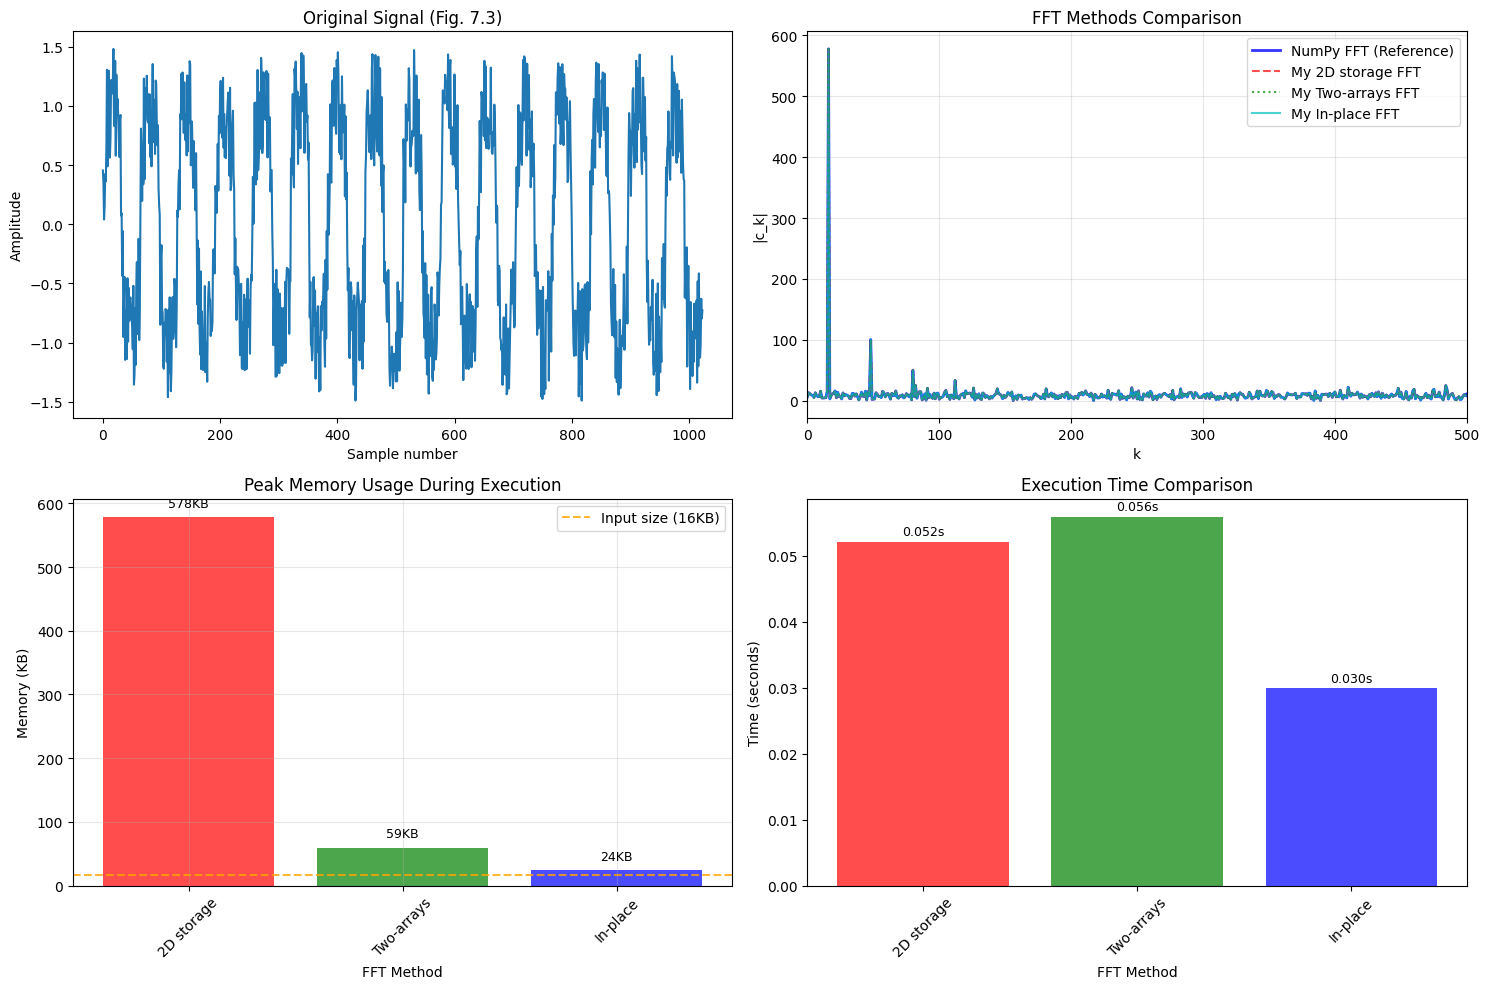

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from math import log2, pi, exp, cos, sin

def my_fft_2d_storage(y):
    """
    Fast Fourier Transform using 2D array storage approach.
    Stores ALL intermediate results from ALL recursion levels in a 2D structure.
    Uses N * (1 + log2(N)) total storage as mentioned in textbooks.
    """
    N = len(y)
    
    if N & (N - 1) != 0:
        raise ValueError("N must be a power of 2")
    
    levels = int(log2(N)) + 1
    
    # Create 2D storage: store ALL intermediate results
    # storage[level] contains all transforms at that recursion level
    storage = {}
    for level in range(levels):
        storage[level] = {}
    
    def fft_with_full_storage(y_segment, level=0, segment_id=0):
        """Store every intermediate result at every level"""
        n = len(y_segment)
        y_segment = np.array(y_segment, dtype=complex)
        
        # Store input at this level
        storage[level][segment_id] = y_segment.copy()
        
        if n == 1:
            return y_segment
        
        # Recursively process even and odd parts
        even = fft_with_full_storage(y_segment[0::2], level + 1, segment_id * 2)
        odd = fft_with_full_storage(y_segment[1::2], level + 1, segment_id * 2 + 1)
        
        # Combine results  
        combined = np.zeros(n, dtype=complex)
        for k in range(n // 2):
            twiddle = complex(cos(-2*pi*k/n), sin(-2*pi*k/n))
            combined[k] = even[k] + twiddle * odd[k]
            combined[k + n//2] = even[k] - twiddle * odd[k]
        
        # Store the combined result at this level
        storage[level][segment_id] = combined.copy()
        
        return combined
    
    # Execute with full storage
    result = fft_with_full_storage(y)
    
    # The storage now contains N * (1 + log2(N)) total elements
    # Level 0: 1 array of size N
    # Level 1: 2 arrays of size N/2 each = N total
    # Level 2: 4 arrays of size N/4 each = N total
    # etc.
    
    return result[:N//2 + 1]

def my_fft_two_arrays(y):
    """
    Fast Fourier Transform using two-array approach.
    Storage with only two arrays: current level and previous level.
    """
    N = len(y)
    
    if N & (N - 1) != 0:
        raise ValueError("N must be a power of 2")
    
    # Two arrays: current and previous level
    current_level = np.zeros(N, dtype=complex)
    prev_level = np.zeros(N, dtype=complex)
    
    def fft_two_arrays_recursive(y_segment, offset=0, level_size=N):
        """Recursive helper that uses only two global arrays for storage"""
        n = len(y_segment)
        
        if n == 1:
            # Base case: store in current_level at the appropriate offset
            current_level[offset] = y_segment[0]
            return
        
        # Split into even and odd 
        even_segment = y_segment[0::2]
        odd_segment = y_segment[1::2]
        
        # Process even part first - stores results in current_level
        fft_two_arrays_recursive(even_segment, offset, level_size // 2)
        
        # Copy current results to prev_level for even part
        for i in range(n // 2):
            prev_level[offset + i] = current_level[offset + i]
        
        # Process odd part - stores results in current_level
        fft_two_arrays_recursive(odd_segment, offset + n // 2, level_size // 2)
        
        # Copy current results to prev_level for odd part  
        for i in range(n // 2):
            prev_level[offset + n // 2 + i] = current_level[offset + n // 2 + i]
        
        # Now combine even and odd using the two arrays
        # Even results are in prev_level[offset:offset+n//2]
        # Odd results are in prev_level[offset+n//2:offset+n]
        for k in range(n // 2):
            twiddle = complex(cos(-2*pi*k/n), sin(-2*pi*k/n))
            even_val = prev_level[offset + k]
            odd_val = prev_level[offset + k + n // 2]
            
            # Store combined results in current_level 
            current_level[offset + k] = even_val + twiddle * odd_val
            current_level[offset + k + n // 2] = even_val - twiddle * odd_val
    
    # Execute the two-array recursive FFT
    fft_two_arrays_recursive(np.array(y, dtype=complex))
    
    return current_level[:N//2 + 1]

# Additional implementation: In-place FFT (the ambitious approach!)
def my_fft_inplace(y):
    """
    In-place FFT implementation - the "not for the faint-hearted" approach.
    This uses only one array and is the most memory efficient.
    """
    N = len(y)
    
    if N & (N - 1) != 0:
        raise ValueError("N must be a power of 2")
    
    # Convert to complex array
    y = np.array(y, dtype=complex)
    
    # Bit-reverse the input array (this is the tricky part!)
    def bit_reverse(n, bits):
        result = 0
        for i in range(bits):
            if (n >> i) & 1:
                result |= 1 << (bits - 1 - i)
        return result
    
    bits = int(log2(N))
    for i in range(N):
        j = bit_reverse(i, bits)
        if i < j:
            y[i], y[j] = y[j], y[i]
    
    # Perform FFT in-place
    size = 2
    while size <= N:
        half_size = size // 2
        
        for start in range(0, N, size):
            for k in range(half_size):
                # Calculate twiddle factor
                angle = -2 * pi * k / size
                twiddle = complex(cos(angle), sin(angle))
                
                # Get indices
                even_idx = start + k
                odd_idx = start + k + half_size
                
                # Butterfly operation
                even_val = y[even_idx]
                odd_val = y[odd_idx]
                
                y[even_idx] = even_val + twiddle * odd_val
                y[odd_idx] = even_val - twiddle * odd_val
        
        size *= 2
    
    # For real input, return first N//2 + 1 coefficients
    return y[:N//2 + 1]

# Test with the pitch.txt data
def test_fft_implementations():
    """Test our FFT implementations against numpy's FFT and with pitch.txt data."""
    
    # Load pitch data
    pitch_data = np.loadtxt('../cpresources/pitch.txt') # MODIFY YOUR DATA INPUT PATH HERE.
    
    # Pad to next power of 2 if needed
    N_orig = len(pitch_data)
    N_padded = 2**int(np.ceil(log2(N_orig)))
    y_padded = np.zeros(N_padded)
    y_padded[:N_orig] = pitch_data
    
    print(f"Original data length: {N_orig}")
    print(f"Padded to power of 2: {N_padded}")
    
    import time
    import tracemalloc
    
    # Test three implementations with timing and memory profiling
    methods = [
        ("2D storage", my_fft_2d_storage, lambda x: x),
        ("Two-arrays", my_fft_two_arrays, lambda x: x),
        ("In-place", my_fft_inplace, lambda x: x)
    ]
    
    results = {}
    
    for name, method, postprocess in methods:
        try:
            print(f"\nTesting {name} approach...")
            
            # Start memory tracing
            tracemalloc.start()
            start_time = time.time()
            
            result = method(y_padded.copy())  # Use copy to avoid modifying original
            
            end_time = time.time()
            # Get peak memory usage
            current, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            
            results[name] = {
                'result': result,
                'time': end_time - start_time,
                'memory_current': current,
                'memory_peak': peak,
                'success': True
            }
            print(f"✓ {name} approach completed in {end_time - start_time:.4f}s")
            print(f"  Peak memory: {peak / 1024:.1f} KB")
        except Exception as e:
            print(f"✗ {name} approach failed: {e}")
            tracemalloc.stop()  # Make sure to stop tracing even on error
            results[name] = {
                'result': None,
                'time': None,
                'memory_current': 0,
                'memory_peak': 0,
                'success': False
            }
    
    # Extract results for backward compatibility
    c1 = results['2D storage']['result']
    c2 = results['Two-arrays']['result']
    c3 = results['In-place']['result']
    
    # Compare with numpy's FFT
    c_numpy = np.fft.rfft(y_padded)
    
    print(f"\nNumpy FFT result shape: {c_numpy.shape}")
    
    # Analyze actual memory usage during execution
    print("\n" + "="*50)
    print("ACTUAL MEMORY USAGE ANALYSIS")
    print("="*50)
    
    # Print measured memory usage
    for name in results:
        if results[name]['success']:
            peak_kb = results[name]['memory_peak'] / 1024
            current_kb = results[name]['memory_current'] / 1024
            time_taken = results[name]['time']
            print(f"\n{name:12}:")
            print(f"  Peak Memory: {peak_kb:.1f} KB")
            print(f"  Final Memory: {current_kb:.1f} KB")
            print(f"  Time: {time_taken:.4f}s")
        else:
            print(f"\n{name:12}: Failed")
    
    # Calculate memory efficiency relative to input size
    input_size_kb = (N_padded * 16) / 1024  # Complex128 = 16 bytes per element
    print(f"\nInput data size: {input_size_kb:.1f} KB")
    
    print("\nMemory efficiency (Peak / Input ratio):")
    for name in results:
        if results[name]['success']:
            peak_kb = results[name]['memory_peak'] / 1024
            ratio = peak_kb / input_size_kb if input_size_kb > 0 else 0
            print(f"  {name:12}: {ratio:.1f}x input size")
    
    # Create plots to duplicate Fig. 7.4
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Original signal (recreate Fig. 7.3)
    plt.subplot(2, 2, 1)
    plt.plot(pitch_data)
    plt.title("Original Signal (Fig. 7.3)")
    plt.xlabel("Sample number")
    plt.ylabel("Amplitude")
    
    # Plot 2: FFT Comparison (overlay)
    plt.subplot(2, 2, 2)
    plt.plot(np.abs(c_numpy), 'b-', alpha=0.8, linewidth=2, label='NumPy FFT (Reference)')
    
    colors = ['r--', 'g:', 'c-']
    method_names = ['2D storage', 'Two-arrays', 'In-place']
    for name, color in zip(method_names, colors):
        if name in results and results[name]['success'] and results[name]['result'] is not None:
            result = results[name]['result']
            plt.plot(np.abs(result[:500]), color, alpha=0.7, label=f'My {name} FFT')
    
    plt.title("FFT Methods Comparison")
    plt.xlim(0, 500)
    plt.xlabel("k")
    plt.ylabel("|c_k|")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Actual Memory Usage Analysis
    plt.subplot(2, 2, 3)
    method_names = [name for name in results if results[name]['success']]
    memory_kb = [results[name]['memory_peak'] / 1024 for name in method_names]
    
    bars = plt.bar(method_names, memory_kb, alpha=0.7, 
                  color=['red', 'green', 'blue'][:len(method_names)])
    plt.title("Peak Memory Usage During Execution")
    plt.ylabel("Memory (KB)")
    plt.xlabel("FFT Method")
    plt.xticks(rotation=45)
    
    # Add memory values on top of bars
    for bar, mem_val in zip(bars, memory_kb):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(memory_kb)*0.02, 
                f'{mem_val:.0f}KB', ha='center', va='bottom', fontsize=9)
    
    # Add input size reference line
    input_size_kb = (N_padded * 16) / 1024
    plt.axhline(y=input_size_kb, color='orange', linestyle='--', alpha=0.8, 
               label=f'Input size ({input_size_kb:.0f}KB)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Timing Analysis
    plt.subplot(2, 2, 4)
    timing_names = [name for name in results if results[name]['success'] and results[name]['time'] is not None]
    timing_values = [results[name]['time'] for name in timing_names]
    
    if timing_names:
        bars = plt.bar(timing_names, timing_values, alpha=0.7,
                      color=['red', 'green', 'blue', 'orange'][:len(timing_names)])
        plt.title("Execution Time Comparison")
        plt.ylabel("Time (seconds)")
        plt.xlabel("FFT Method")
        plt.xticks(rotation=45)
        
        # Add timing values on top of bars
        for bar, time_val in zip(bars, timing_values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(timing_values)*0.01, 
                    f'{time_val:.3f}s', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    return c_numpy, c1, c2, c3

if __name__ == "__main__":
    test_fft_implementations()